In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import illustris_python as il

#constants
h_tng = 0.678 #Planck 2015
h_b = 0.7 #behroozi
h_m = 0.704 #moster
h_z = 0.7
G = 4.3*10**(-6) #  kpc/M_o*(km/s)**2

In [2]:
def masses(df):
    keys = df.keys()
    for key in keys:
        if "Mass" in key:
            df[key] = df[key]*10**10/h_tng
    return df

def color(df):
    bands = ["g", "r", "i"]
    for i in range(3):
        for j in range(i+1, 3):
            key1 = "SubhaloStellarPhotometrics_" + bands[i]
            key2 = "SubhaloStellarPhotometrics_" + bands[j]
            for key in df.keys():
                if (key1 in key):
                    radkey = key.replace(key1, "")
                    if (key2 + radkey) in df.keys():
                        df["SubhaloColor_" + bands[i] + "-" + bands[j] + radkey] = df[key1 + radkey] - df[key2 + radkey]
    return df

def double_power_law(b, c, M1, N):
    xmin, xmax = 9, 14
    x=np.logspace(xmin,xmax,200)
    y = 2*N*x*((x/M1)**(-b)+(x/M1)**(c))**(-1)
    return x,y

def behroozi(a, M1, c, d, e):
    def f(x):
        f = -np.log10(10**(a*x)+1)+d*((np.log10(1+np.exp(x)))**c)/(1+np.exp(10**(-x)))
        return f
    xmin, xmax = 9, 14
    X=np.logspace(xmin,xmax,200)
    Y_log = np.log10(e*M1)+f(np.log10(X/M1)) - f(0) #gives log(y)
    return X, 10**(Y_log)

In [3]:
def late_type_SFR(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] < 0.036].index
    df_copy = df_copy.drop(index_names)
    
    return df_copy

def early_type_SFR(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] > 0.01148].index
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_gas(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction"] < 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_gas(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction"] > 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_kappa(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot"] < 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_kappa(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot"] > 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def clean_subhalos(df, idlist):
    df_copy = df.copy(deep=True)
    index_names = np.array([])
    df_id = np.array(df_copy["id"])
    for item in df_id:
        if item not in idlist:
            print(item)
            index_names = np.append(index_names, df_copy[df_copy["id"]==item].index)
    print(index_names)
    df_copy = df_copy.drop(index_names)
    return df_copy

In [4]:
old = pd.read_pickle("../data/tng-100-1/cutdata/Subhalo_Centrals_minE9_5_SM.pkl")
general = pd.read_pickle("../data/tng-100-1/catalogues/mass_vel_photo_2303.pkl")
vel = pd.read_pickle("../data/tng-100-1/catalogues/velocities_1903.pkl")
aper = pd.read_pickle("../data/tng-100-1/catalogues/apertures_0704.pkl")
new1 = general.join(vel, lsuffix="DROP").filter(regex="^(?!.*DROP)")
new = aper.join(new1, lsuffix="DROP").filter(regex="^(?!.*DROP)")
sami = pd.read_csv("../data/SAMI/all_data_vrot.csv")
old.sort_values(by="id", inplace = True)
new.sort_values(by="id", inplace = True)
new = clean_subhalos(new, list(old["id"]))

print(len(old), len(new), len(vel))

#Masses
old = masses(old)
new = masses(new)

#sSFR and gas fraction
new["SubhalosSFR"] = 10**(9)*new["SubhaloSFR"]/new["SubhaloMassStellar"]
new["SubhaloGasFraction"] = new["SubhaloMassInHalfRadGas"]/new["SubhaloMassInHalfRadStellar"]

old["SubhalosSFR"] = 10**(9)*old["SubhaloSFR"]/old["SubhaloMassStellar"]
old["SubhaloGasFraction"] = old["SubhaloMassGas"]/old["SubhaloMassStellar"]

#Half mass rad

new["SubhaloHalfmassRadProj"] = ((new["SubhaloHalfmassRad_xy"]**2 + new["SubhaloHalfmassRad_xz"]**2 + new["SubhaloHalfmassRad_yz"]**2)*(1/3))**(1/2)

#Adding color
new = color(new)
old = color(old)


464331
469502
485326
489356
[1132. 1215. 1496. 1579.]
5873 5873 5877


In [6]:
for key in new.keys():
    if "3D" in key:
        new_key = key.replace("3D", "1D")
        new[new_key] = new[key]*(1/3)**(1/2)

In [7]:
new_earlies = early_type_kappa(early_type_SFR(new))
new_lates = late_type_kappa(late_type_SFR(new))

new_earlies_id = new_earlies["id"].values
new_lates_id = new_lates["id"].values
new_id = new["id"].values

old_earlies = old[old["id"].isin(new_earlies_id)]
old_lates = old[old["id"].isin(new_lates_id)]
old = old[old["id"].isin(new_id)]

#Log format
new_log = il.formatplot.log_formater(new)
old_log = il.formatplot.log_formater(old)
new_earlies_log = il.formatplot.log_formater(new_earlies)
old_earlies_log = il.formatplot.log_formater(old_earlies)
new_lates_log = il.formatplot.log_formater(new_lates)
old_lates_log = il.formatplot.log_formater(old_lates)


print(len(new_earlies), len(new_lates), len(new)-len(new_earlies)-len(new_lates))
print(len(old_earlies), len(old_lates), len(old)-len(old_earlies)-len(old_lates))


1310 1225 3338
1310 1225 3338


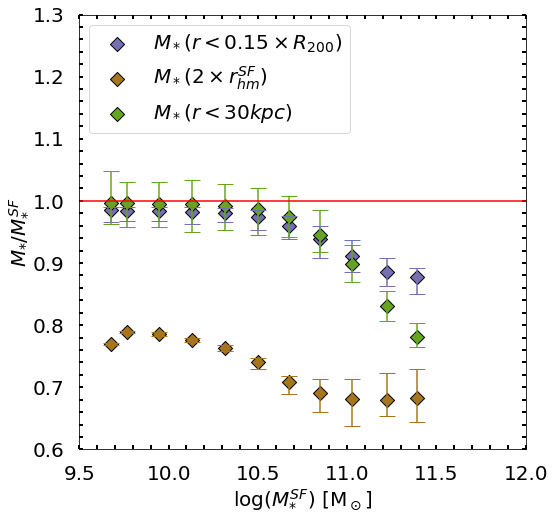

In [8]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = old["SubhaloMassStellar"].values
new_vals_1 = new["SubhaloMassStellar"].values
new_vals_2 = new["SubhaloMassStellar30kpc"].values
new_vals_3 = old["SubhaloMassInRadStellar"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$M_*(r < 0.15 \times R_{200}$)")
axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"$M_*(2 \times r^{SF}_{hm})$")
axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$M_*(r < 30 kpc$)")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fSM(ax=axs, y0 = 0.6, y1 = 1.3)

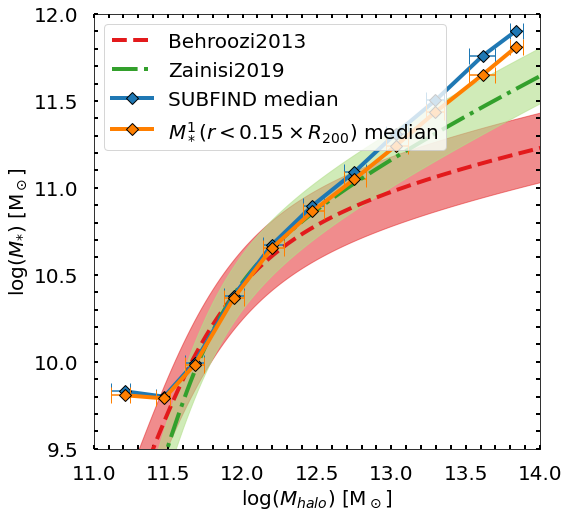

In [9]:
#Create the plot
fig, ax = plt.subplots(figsize = (8,8))

#Moster 2012
M2012x, M2012y = double_power_law(b = 1.376, c = 0.608,M1 = 10**11.590, N = 0.0351)
#converting to same cosmology
M2012x = M2012x*h_m/h_tng
M2012y = M2012y*h_m**2/h_tng**2
#ax2.plot(np.log10(M2012x),np.log10(M2012y), c="#7570b3", linewidth=4, label= "Moster2012")

#Behroozi 2013
B2013x, B2013y = behroozi(a=-1.412, M1=10**(11.514), c=0.316, d=3.508, e=10**(-1.777))
#converting to same cosmology
B2013x = B2013x*h_b/h_tng
B2013y = B2013y*h_b**2/h_tng**2
#Adding maximum error in log format
B_err_lower = np.log10(B2013y) - 0.2
B_err_upper = np.log10(B2013y) + 0.2
ax.plot(np.log10(B2013x), np.log10(B2013y), "--", c="#e31a1c", linewidth=4, label= "Behroozi2013")
ax.fill_between(np.log10(B2013x), B_err_lower, B_err_upper, alpha=0.5, color="#e31a1c")

#Zainisi 2019
Z2019x, Z2019y = behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785))
#converting to same cosmology
Z2019x = Z2019x*h_z/h_tng
Z2019y = Z2019y*h_z**2/h_tng**2
#Adding maximum error in log format
#Z_errors = il.stats.error_estimate_behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785), delta_a=0.026, delta_M1=0.008, delta_c=0.1, delta_d=0.052, delta_e=0.01, x=Z2019x)
Z_err_lower = np.log10(Z2019y) - 0.16 #Z_errors
Z_err_upper = np.log10(Z2019y) + 0.16 #Z_errors
ax.plot(np.log10(Z2019x), np.log10(Z2019y), "-.", c="#33a02c", linewidth=4, label= "Zainisi2019")
ax.fill_between(np.log10(Z2019x), Z_err_lower, Z_err_upper, alpha=0.6, color="#b2df8a")

#Calculate mean values TNG
SF_x = old_log["SubhaloMass"].values
SF_y = old_log["SubhaloMassStellar"].values
mSF_x, mSF_y, eSF_x, eSF_y = il.stats.median_errors(SF_x, SF_y, 11, 14)
#eTNG_x, eTNG_y = il.stats.log_errors(eTNG_x, eTNG_y, mTNG_x, mTNG_y)
ax.errorbar(mSF_x, mSF_y, xerr=eSF_x, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
ax.plot(mSF_x, mSF_y, marker='D', linewidth=4, markersize=8, c="#1f78b4", markeredgecolor = "black", label = "SUBFIND median")

#Calculate mean values TNG
TNG_x = old_log["SubhaloMass"].values
TNG_y = new_log["SubhaloMassStellar"].values
mTNG_x, mTNG_y, eTNG_x, eTNG_y = il.stats.median_errors(TNG_x, TNG_y, 11, 14)
#eTNG_x, eTNG_y = il.stats.log_errors(eTNG_x, eTNG_y, mTNG_x, mTNG_y)
ax.errorbar(mTNG_x, mTNG_y, xerr=eTNG_x, capsize = 8, color="#ff7f00", marker='^', fmt = 'none')
ax.plot(mTNG_x, mTNG_y, marker='D', linewidth=4, markersize=8, c="#ff7f00", markeredgecolor = "black", label = r"$M^1_*(r < 0.15 \times R_{200})$ median")

il.formatplot.HM_SM(ax=ax, y0=9.5, y1=12, x0=11, x1=14)
#plt.savefig("../fig/results_shmr.png", dpi=300, bbox_inches='tight')

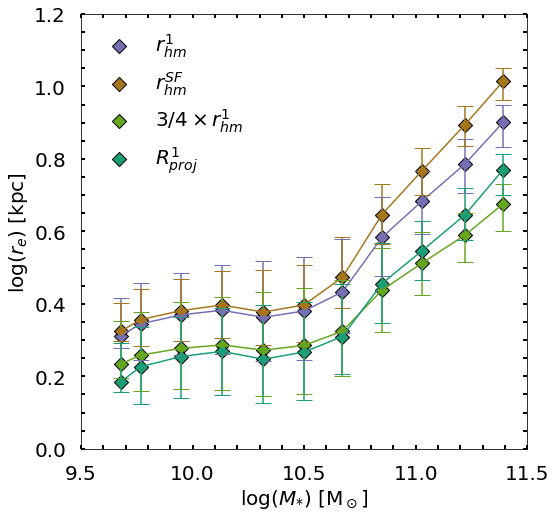

In [10]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
x_vals_log = old_log["SubhaloMassStellar"].values
new_vals_1 = new_log["SubhaloHalfmassRadStellar"].values
new_vals_2 = new_log["SubhaloHalfmassRadStellar"].values*3/4
old_vals = old_log["SubhaloHalfmassRadStellar"].values
new_vals_3 = new_log["SubhaloHalfmassRadProj"].values
#new_vals_3 = old["SubhaloMassInRadStellar"].values

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(x_vals_log, new_vals_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_log, new_vals_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_log, old_vals, 9.5, 11.5)
x_med4, y_med4, x_err4, y_err4 = il.stats.median_errors(x_vals_log, new_vals_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$r^1_{hm}$")
axs.plot(x_med1, y_med1, marker='D', color="#7570b3")

axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"$r^{SF}_{hm}$")
axs.plot(x_med3, y_med3, marker='D', color="#a6761d")

axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$3/4 \times r^1_{hm}$")
axs.plot(x_med2, y_med2, marker='D', color="#66a61e")

axs.errorbar(x_med4, y_med4, yerr=y_err4, capsize = 8, color="#1b9e77", marker='^', fmt = 'none')
axs.scatter(x_med4, y_med4, marker='D', s=100, color="#1b9e77", edgecolors = "black", label = r"$R^1_{proj}$")
axs.plot(x_med4, y_med4, marker='D', color="#1b9e77")

il.formatplot.SM_R(ax=axs, x0= 9.5, x1= 11.5, y0=0, y1=1.2)

In [12]:
print(new.keys())

Index(['SubhaloRad200', 'SubhaloSFR30kpc', 'SubhaloMassGas30kpc',
       'SubhaloMassDM30kpc', 'SubhaloMassStellar30kpc', 'SubhaloMass30kpc',
       'SubhaloHalfmassRadStellar30kpc', 'SubhaloMassInHalfRad30kpcGas',
       'SubhaloMassInHalfRad30kpcDM', 'SubhaloMassInHalfRad30kpcStellar',
       'SubhaloMassInHalfRad30kpc', 'SubhaloMassInRad30kpcGas',
       'SubhaloMassInRad30kpcDM', 'SubhaloMassInRad30kpcStellar',
       'SubhaloRotVel2Re30kpc', 'SubhaloHalfmassRad_xy30kpc',
       'SubhaloHalfmassRad_xz30kpc', 'SubhaloHalfmassRad_yz30kpc',
       'SubhaloVelDispStellarRe30kpc', 'SubhaloStellarPhotometrics_g30kpc',
       'SubhaloStellarPhotometrics_r30kpc',
       'SubhaloStellarPhotometrics_i30kpc',
       'SubhaloStellarPhotometrics_z30kpc', 'SubhaloMassInHalfRadGas',
       'SubhaloMassInHalfRadDM', 'SubhaloMassInHalfRadStellar',
       'SubhaloMassInHalfRad', 'SubhaloMassInRadGas', 'SubhaloMassInRadDM',
       'SubhaloMassInRadStellar', 'AngularMomentumX', 'AngularMomentumY',
   

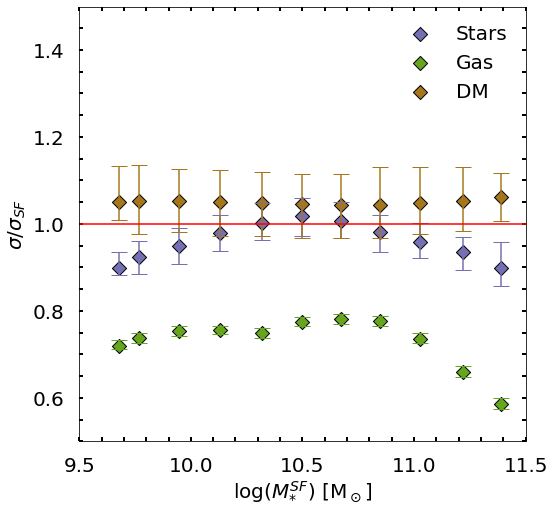

In [13]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = old["SubhaloVelDisp"].values
new_vals_1 = new["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new["SubhaloVelDispTotalGas1D"].values
new_vals_3 = new["SubhaloVelDispTotalDM1D"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"Stars")

axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"Gas")

axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"DM")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)

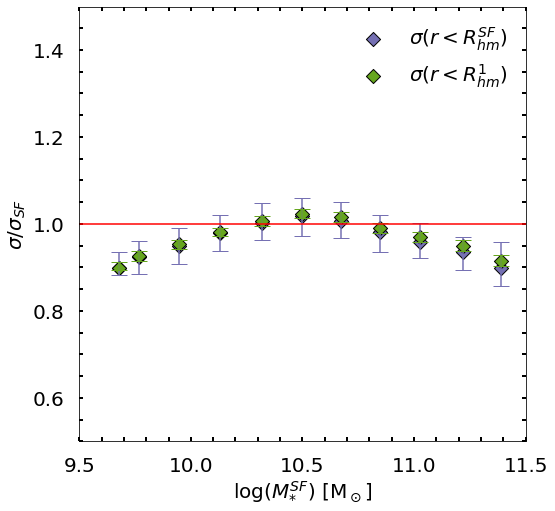

In [14]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = old["SubhaloVelDisp"].values
new_vals_1 = new["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new["SubhaloVelDispStellar1D"].values
#new_vals_3 = new["SubhaloVelDispTotalDM1D"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
#frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$\sigma(r < R^{SF}_{hm})$")

axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$\sigma(r <R^1_{hm})$")

#axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
#axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"DM")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


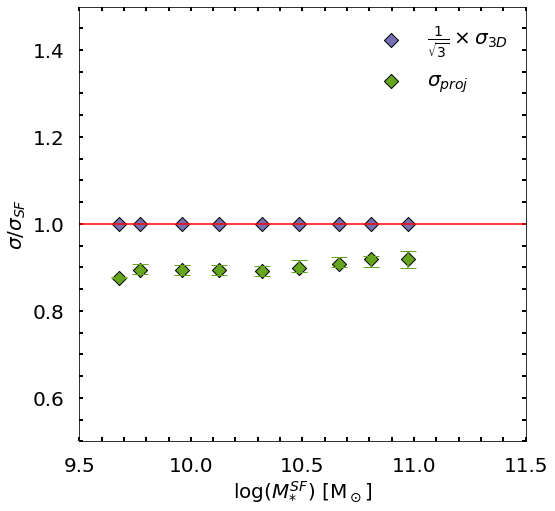

In [15]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_lates_log["SubhaloMassStellar"].values
old_vals = new_lates["SubhaloVelDispTotalStellar1D"].values
new_vals_1 = new_lates["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new_lates["SubhaloVelDispTotalStellar"].values
#new_vals_3 = new["SubhaloVelDispTotalDM1D"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
#frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
#x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$\frac{1}{\sqrt{3}} \times \sigma_{3D}$")

axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$\sigma_{proj}$")

#axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
#axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"DM")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)

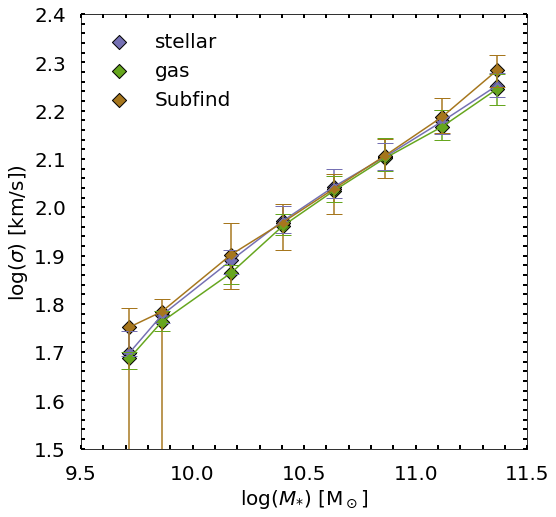

In [16]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
x_vals_log = old_earlies_log["SubhaloMassStellar"].values
new_vals_1 = new_earlies_log["SubhaloVelDispStellar"].values
new_vals_2 = new_earlies_log["SubhaloVelDispGas1D"].values
old_vals_1 = old_earlies_log["SubhaloVelDisp"].values
#sami_vals_3 = sami["SubhaloMassInRadStellar"].values

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(x_vals_log, new_vals_1, 9.5, 11.5, n=9)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_log, new_vals_2, 9.5, 11.5, n=9)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_log, old_vals_1, 9.5, 11.5, n=9)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"stellar")
axs.plot(x_med1, y_med1, marker='D', color="#7570b3")

axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"gas")
axs.plot(x_med2, y_med2, marker='D', color="#66a61e")

axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"Subfind")
axs.plot(x_med3, y_med3, marker='D', color="#a6761d")

il.formatplot.SM_VD(ax=axs, x0= 9.5, x1= 11.5, y0=1.5, y1=2.4)

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


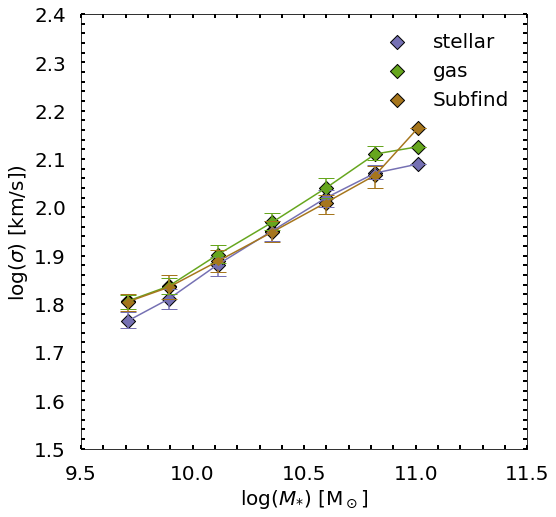

In [17]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
x_vals_log = old_lates_log["SubhaloMassStellar"].values
new_vals_1 = new_lates_log["SubhaloVelDispStellar1D"].values
new_vals_2 = new_lates_log["SubhaloVelDispGas1D"].values
old_vals_1 = old_lates_log["SubhaloVelDisp"].values
#sami_vals_3 = sami["SubhaloMassInRadStellar"].values

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(x_vals_log, new_vals_1, 9.5, 11.5, n=9)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_log, new_vals_2, 9.5, 11.5, n=9)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_log, old_vals_1, 9.5, 11.5, n=9)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"stellar")
axs.plot(x_med1, y_med1, marker='D', color="#7570b3")

axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"gas")
axs.plot(x_med2, y_med2, marker='D', color="#66a61e")

axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"Subfind")
axs.plot(x_med3, y_med3, marker='D', color="#a6761d")

il.formatplot.SM_VD(ax=axs, x0= 9.5, x1= 11.5, y0=1.5, y1=2.4)

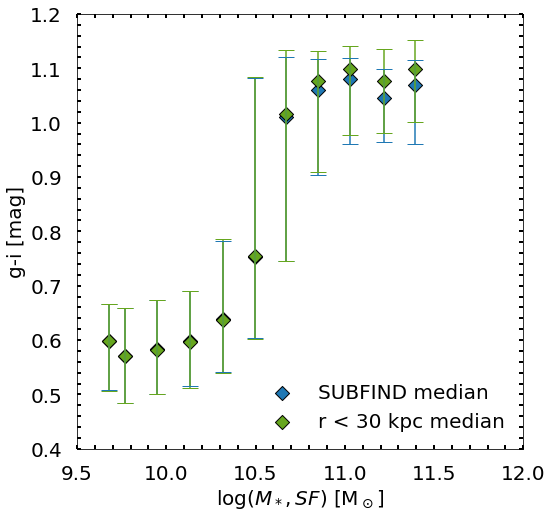

In [22]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = np.array(old["SubhaloColor_g-i"].values)
new_vals_1 = np.array(new["SubhaloColor_g-i"].values)
new_vals_2 = np.array(new["SubhaloColor_g-i30kpc"].values)


x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, old_vals, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, new_vals_2, 9.5, 11.5)

#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"SUBFIND median")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"r < 30 kpc median")

il.formatplot.SM_fC(ax=axs, color="g-i", y0=0.4, y1=1.2)

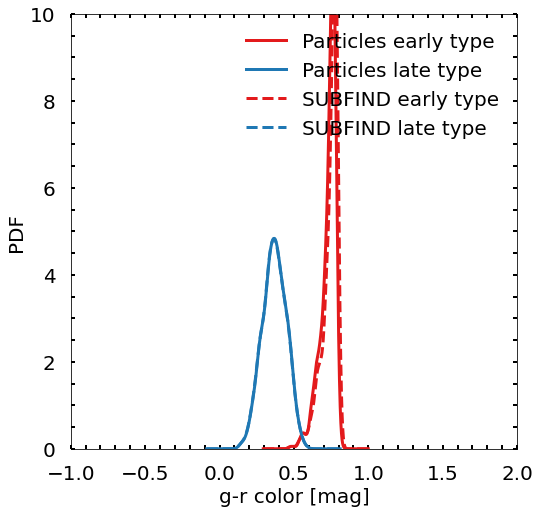

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
ser1, ser2 = old_earlies["SubhaloColor_g-r"], old_lates["SubhaloColor_g-r"]
ser3, ser4 = new_earlies["SubhaloColor_g-r30kpc"], new_lates["SubhaloColor_g-r30kpc"]
ser1.plot.kde(ax=ax, color = '#e31a1c', linewidth=3, label="Particles early type")
ser2.plot.kde(ax=ax, color = '#1f78b4', linewidth=3, label="Particles late type")
ser3.plot.kde(ax=ax, label="SUBFIND early type", color = '#e31a1c', linewidth=3, linestyle="--")
ser4.plot.kde(ax=ax, label="SUBFIND late type", color = '#1f78b4', linewidth=3, linestyle="--")
il.formatplot.PDF_C('g-r', ax, legend_on=True, y1=10)
